In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.policies import policy_saver

2023-06-04 14:29:38.514258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-04 14:29:41.524760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:29:41.531228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:29:41.531544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  True,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 2,
"step_size" : 4,
"pred_session_name" : 'rand_walk_interpol',
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-06-04 14:29:51.882367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:29:51.883138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:29:51.883399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
INFO:tensorflow:Reduce to 

2023-06-04 14:29:57.944596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:29:57.944801: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 14:29:57.944907: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 14:29:57.945171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:29:57.945349: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-04 14:29:59.394102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:29:59.394309: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 14:29:59.394438: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 14:29:59.395129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:29:59.395390: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-04 14:30:04.008644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:30:04.008874: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 14:30:04.009222: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 14:30:04.010247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:30:04.010500: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-04 14:30:04.846001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:30:04.846266: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 14:30:04.847000: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 14:30:04.847989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:30:04.848246: I tensorflow/compiler/xla/stream_executor/

In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-04--14:30:06'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_step = train_py_env.reset()
        reward_in_episode = 0
        while not time_step.is_last():
            time_step = train_py_env.step(action=1)
            reward_in_episode += time_step.reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

2023-06-04 14:30:08.201159: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-04 14:30:08.201339: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-04 14:30:17.307034: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 18.92477035522461
Average error 21.075230530566436


Timer unit: 0.001 s

Total time: 129.034 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 468

Line #      Hits         Time  Per Hit   % Time  Line Contents
   468                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   469        52          1.4      0.0      0.0  		city_ob = self.building_grid
   470        52          1.4      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   471        52          1.6      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   472                                           
   473                                           		# Get measured coords
   474        52         10.7      0.2      0.0  		measured_coords = self.get_measured_coords()
   475                                           
   476                                           		# UAV location grid
   477        52          2.0      0.0      0.0  		uav_location_grid

In [12]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [13]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-04 14:32:16.881203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-04 14:32:17.755564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
# Define eval function
def compute_avg_return(environment, py_environment, policy, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    episode_errors.append(py_environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], np.mean(episode_errors)

In [15]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error = compute_avg_return(eval_env, eval_py_env, random_policy, num_episodes=1)

print((rand_reward, rand_pred_error))


(15.477117, 24.522883768912703)


In [16]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,     
  sequence_length=n_step_update+1)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp7otkqtq_.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp7otkqtq_
[reverb/cc/platform/default/server.cc:71] Started replay server on port 43373


In [17]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())




Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([[[0.35221046, 0.17539784, 0.        ],
         [0.22787906, 0.18529814, 0.        ],
         [0.29616484, 0.156829  , 0.        ],
         ...,
         [0.3137568 , 0.15997317, 0.        ],
         [0.27322036, 0.1905495 , 0.        ],
         [0.30231267, 0.23413691, 0.        ]],
 
        [[0.33952728, 0.19492395, 0.        ],
         [0.        , 0.20636192, 0.        ],
         [0.        , 0.1712864 , 0.        ],
         ...,
         [0.        , 0.19971402, 0.        ],
         [0.        , 0.1694747 , 0.        ],
         [0.        , 0.18785797, 0.        ]],
 
        [[0.4159549 , 0.20941004, 0.        ],
         [0.        , 0.30329666, 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.20437585, 0.        ],
         [0.        , 0.17854433, 0.        ]],
 
        ...,
 
        [[0.5314244 ,

In [18]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [19]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [20]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [21]:
env._reset()
print("")

In [22]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [23]:
best_reward = np.inf
losses = []
collect_rewards = []

In [24]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [25]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)


for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step.reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}'.format(step, avg_return, avg_error))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
      avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
      print('step = {0}: Average Return 2 = {1}, Average Error 2 = {2}'.format(step, avg_return, avg_error))
      print('step = {0}: Average Return 3 = {1}, Average Error 3 = {2}'.format(step, avg_return_collect, avg_error_collect))

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1998521) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1998521) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1998521) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1998521) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1998521) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1998521) so Table uniform_table is accessed directly without gRPC.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
2023-06-04 14:47:54.113182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum' with dtype int32
	 [[{{node critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum}}]]
2023-06-04 14:47:54.121085: I tensorflow/core/common_runtime/executor.cc:1197] [/d

step = 0: loss = 4.249208450317383,  rew = 0.0
step = 0: Average Return = 19.790674209594727, Average Error = 20.766978509783826
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


step = 0: Average Return 2 = 19.1780948638916, Average Error 2 = 21.725231518909872
step = 0: Average Return 3 = 20.382137298583984, Average Error 3 = 19.937435190501663
step = 1000: loss = 4.199301719665527,  rew = 20.74611335992813
step = 2000: loss = 4.1492414474487305,  rew = 21.454843878746033
step = 3000: loss = 4.09873104095459,  rew = 20.747563242912292
step = 4000: loss = 4.045633316040039,  rew = 21.328356862068176
step = 5000: loss = 3.9938979148864746,  rew = 22.288882732391357
step = 6000: loss = 3.943838596343994,  rew = 20.677097141742706
step = 7000: loss = 3.9042041301727295,  rew = 21.23114913702011
step = 8000: loss = 3.8572330474853516,  rew = 22.92950004339218
step = 9000: loss = 3.824831485748291,  rew = 21.00328654050827
step = 10000: loss = 3.790769338607788,  rew = 22.15697318315506
step = 11000: loss = 3.781376838684082,  rew = 19.90668922662735
step = 12000: loss = 3.7677195072174072,  rew = 21.36029750108719
step = 13000: loss = 3.7273597717285156,  rew = 20

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


step = 50000: Average Return 2 = 20.27996826171875, Average Error 2 = 20.602421256211144
step = 50000: Average Return 3 = 20.53169822692871, Average Error 3 = 20.112730644633476
step = 51000: loss = 3.5615758895874023,  rew = 22.481723129749298
step = 52000: loss = 3.563739776611328,  rew = 22.652815282344818
step = 53000: loss = 3.6085495948791504,  rew = 22.079552710056305
step = 54000: loss = 3.521376609802246,  rew = 20.011138916015625
step = 55000: loss = 3.5474040508270264,  rew = 23.789098858833313
step = 56000: loss = 3.606451988220215,  rew = 19.572262465953827
step = 57000: loss = 3.5389957427978516,  rew = 17.733123898506165
step = 58000: loss = 3.4727962017059326,  rew = 20.86164802312851
step = 59000: loss = 3.5355429649353027,  rew = 19.79767382144928
step = 60000: loss = 3.5138349533081055,  rew = 20.916685461997986
step = 61000: loss = 3.5231096744537354,  rew = 19.60420459508896
step = 62000: loss = 3.5179007053375244,  rew = 22.582125663757324
step = 63000: loss = 3.4

step = 100000: Average Return = 21.026762008666992, Average Error = 19.479711005672126
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


step = 100000: Average Return 2 = 21.271865844726562, Average Error 2 = 19.34471245236929
step = 100000: Average Return 3 = 20.974807739257812, Average Error 3 = 19.5485908790289
step = 101000: loss = 3.462345838546753,  rew = 20.22368758916855
step = 102000: loss = 3.444984197616577,  rew = 21.899251639842987
step = 103000: loss = 3.432770013809204,  rew = 20.238278806209564
step = 104000: loss = 3.461637258529663,  rew = 21.111135184764862
step = 105000: loss = 3.417837619781494,  rew = 22.681233286857605
step = 106000: loss = 3.5247716903686523,  rew = 20.46445906162262
step = 107000: loss = 3.440819263458252,  rew = 18.123899400234222
step = 108000: loss = 3.444502830505371,  rew = 22.066311538219452
step = 109000: loss = 3.4557576179504395,  rew = 22.28902578353882
step = 110000: loss = 3.470409870147705,  rew = 21.204501390457153
step = 111000: loss = 3.3629016876220703,  rew = 22.126656770706177
step = 112000: loss = 3.450103282928467,  rew = 23.46956729888916
step = 113000: los

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


step = 150000: Average Return 2 = 22.148765563964844, Average Error 2 = 17.890782651426417
step = 150000: Average Return 3 = 21.389558792114258, Average Error 3 = 18.857544835850092
step = 151000: loss = 3.452603340148926,  rew = 22.425149381160736
step = 152000: loss = 3.3503146171569824,  rew = 24.28019940853119
step = 153000: loss = 3.4485440254211426,  rew = 19.844260811805725
step = 154000: loss = 3.4543962478637695,  rew = 23.05222451686859
step = 155000: loss = 3.4556777477264404,  rew = 22.749686241149902
step = 156000: loss = 3.389465093612671,  rew = 21.66629582643509
step = 157000: loss = 3.3787567615509033,  rew = 21.084436774253845
step = 158000: loss = 3.3142249584198,  rew = 19.444476068019867
step = 159000: loss = 3.384190082550049,  rew = 22.58835732936859
step = 160000: loss = 3.3679423332214355,  rew = 22.871585190296173
step = 161000: loss = 3.3362185955047607,  rew = 23.67265075445175
step = 162000: loss = 3.3882346153259277,  rew = 22.9342982172966
step = 163000: 

INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


step = 250000: Average Return 2 = 21.96894645690918, Average Error 2 = 18.145324291185787
step = 250000: Average Return 3 = 21.58978271484375, Average Error 3 = 18.953943380925704
step = 251000: loss = 3.3806891441345215,  rew = 21.241576969623566
step = 252000: loss = 3.259645462036133,  rew = 22.970254719257355
step = 253000: loss = 3.2699332237243652,  rew = 22.250400483608246
step = 254000: loss = 3.3558950424194336,  rew = 23.809723556041718
step = 255000: loss = 3.288691520690918,  rew = 21.50217890739441
step = 256000: loss = 3.3226990699768066,  rew = 21.572597324848175
step = 257000: loss = 3.322272300720215,  rew = 20.903973281383514
step = 258000: loss = 3.3615283966064453,  rew = 19.887883961200714
step = 259000: loss = 3.341940402984619,  rew = 22.002941370010376
step = 260000: loss = 3.3562092781066895,  rew = 18.017221987247467
step = 261000: loss = 3.395420551300049,  rew = 20.445233583450317
step = 262000: loss = 3.3600640296936035,  rew = 22.842273116111755
step = 263

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


step = 1000000: Average Return 2 = 22.209577560424805, Average Error 2 = 18.09453034760617
step = 1000000: Average Return 3 = 22.343080520629883, Average Error 3 = 17.960098960411962
step = 1001000: loss = 3.2911760807037354,  rew = 19.068174064159393
step = 1002000: loss = 3.2987992763519287,  rew = 23.741106688976288
step = 1003000: loss = 3.264237403869629,  rew = 19.627679884433746
step = 1004000: loss = 3.3588616847991943,  rew = 22.995056211948395
step = 1005000: loss = 3.354543924331665,  rew = 20.494498312473297
step = 1006000: loss = 3.345738410949707,  rew = 20.748135447502136
step = 1007000: loss = 3.2733869552612305,  rew = 20.734332501888275
step = 1008000: loss = 3.269416093826294,  rew = 19.53740268945694
step = 1009000: loss = 3.2077221870422363,  rew = 23.968839645385742
step = 1010000: loss = 3.283637523651123,  rew = 19.34697777032852
step = 1011000: loss = 3.2391839027404785,  rew = 20.337222516536713
step = 1012000: loss = 3.2942705154418945,  rew = 20.227138698101

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:30:06/assets


step = 1100000: Average Return 2 = 22.501209259033203, Average Error 2 = 17.535861335875452
step = 1100000: Average Return 3 = 21.740304946899414, Average Error 3 = 18.535473772257756
step = 1101000: loss = 3.2199175357818604,  rew = 20.159754157066345
step = 1102000: loss = 3.2347259521484375,  rew = 23.600077629089355
step = 1103000: loss = 3.3553056716918945,  rew = 21.659336984157562
step = 1104000: loss = 3.319502115249634,  rew = 20.779526233673096
step = 1105000: loss = 3.323871612548828,  rew = 21.80420458316803
step = 1106000: loss = 3.3303680419921875,  rew = 21.944229304790497
step = 1107000: loss = 3.2990989685058594,  rew = 21.904054284095764
step = 1108000: loss = 3.2739405632019043,  rew = 20.191404223442078
step = 1109000: loss = 3.310904026031494,  rew = 20.1847642660141
step = 1110000: loss = 3.2682058811187744,  rew = 23.535770177841187
step = 1111000: loss = 3.3263115882873535,  rew = 21.93579375743866
step = 1112000: loss = 3.341155529022217,  rew = 24.862274527549

Traceback (most recent call last):
  File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1998521/381966556.py", line 18, in <module>
    time_step, _ = collect_driver.run(time_step)
  File "/home/enesk/repos/spatial-prediction/custom_py_driver.py", line 153, in run
    next_time_step = self.env.step(action_step.action)
  File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/environments/py_environment.py", line 232, in step
    self._current_time_step = self._step(action)
  File "/home/enesk/repos/spatial-prediction/rl_env.py", line 228, in _step
  File "/home/enesk/repos/spatial-prediction/active_sensing_environment.py", line 488, in predict_ss
    predictions = self.predictor.forward_pass(np.asarray([ob], dtype=np.float32)).numpy()
  File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorfl

In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

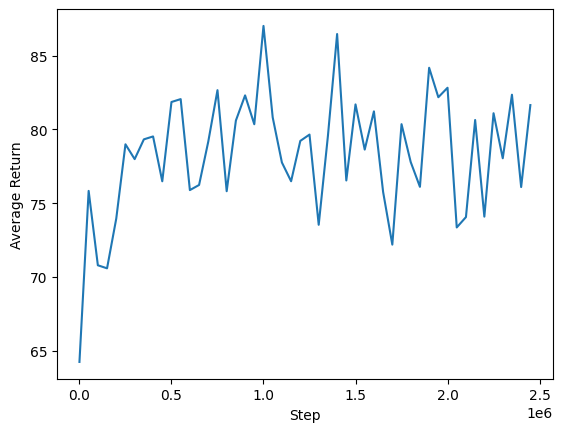

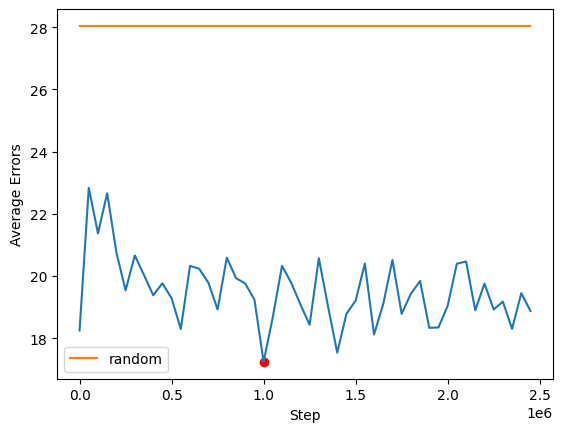

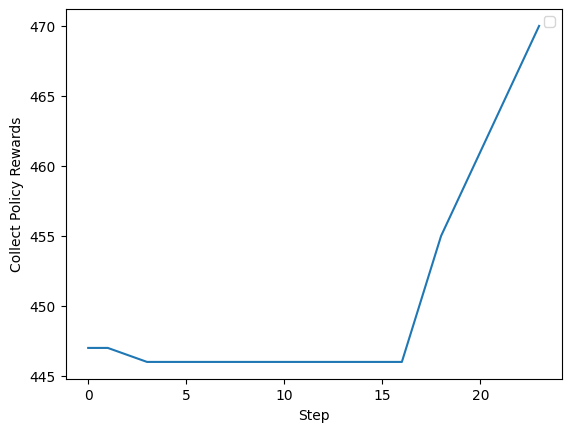

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

22.477695 17.715553957387616


In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

22.378853 17.984891216551663


In [ ]:
saved_policy = tf.saved_model.load(train_log_dir)
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, saved_policy, 500)
print(avg_return, avg_error)

22.074543 18.12299778895943
